# Problem Statement: IMDB Comment Sentiment Classifier

Dataset: For this exercise we will use a dataset hosted at http://ai.stanford.edu/~amaas/data/sentiment/

**Problem Statement**: 
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. 

Launch a spark session, verify the spark session UI

In [1]:
spark.sparkContext.uiWebUrl

'http://198.166.1.126:4040'

IMDB comments dataset has been stored in the following location 

In [2]:
!wc -l data/imdb-comments.json

   50000 data/imdb-comments.json


There are 50000 lines in the file. Let's the first line

In [3]:
!du -sh data/imdb-comments.json

 66M	data/imdb-comments.json


Total size of the file is 66MB

In [4]:
!head -n 1 data/imdb-comments.json

{"label":"test","sentiment":"pos","name":"0_10.txt","content":"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."}


Each line is a self contained json doc. Load the dataset using spark reader specifying the file format as json. As we see above size of the file is 66 MB, we should at least 2 partitons, since I am using dual core system, I will repartition the data to 4. Also will cache the data after repartitioning.

In [5]:
imdb = spark.read.format("json").load("data/imdb-comments.json").repartition(4).cache()

Find total number of records

In [6]:
imdb.count()

50000

Print Schema and view the field types

In [7]:
imdb.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)



Take a look at a few sample data

In [8]:
imdb.show()

+--------------------+-----+------------+---------+
|             content|label|        name|sentiment|
+--------------------+-----+------------+---------+
|Actor turned dire...| test| 10000_7.txt|      pos|
|I saw this film o...| test| 10004_9.txt|      pos|
|"Quitting" may be...| test| 10008_8.txt|      pos|
|I must say, every...| test| 10011_9.txt|      pos|
|Even if you're a ...| test| 10015_8.txt|      pos|
|Since this cartoo...| test| 10019_8.txt|      pos|
|This short is one...| test|10022_10.txt|      pos|
|Warner Brothers t...| test|10026_10.txt|      pos|
|I was fortunate t...| test|  1002_9.txt|      pos|
|The historical in...| test| 10033_8.txt|      pos|
|This movie is goo...| test| 10037_7.txt|      pos|
|Although "They Di...| test|10040_10.txt|      pos|
|George Armstrong ...| test| 10044_8.txt|      pos|
|Although this fil...| test| 10048_8.txt|      pos|
|All in all, an ex...| test| 10051_8.txt|      pos|
|i have to rate th...| test|10055_10.txt|      pos|
|Why does ev

*label* - column indicate whethet the data belong to training or test bucket.
*sentiment* - column indicates whether the comment carries positive or negative sentiment. This column has been manually curated.

Find out for each combination of label and sentimnet how many records are there.

In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [10]:
imdb.groupBy("sentiment").pivot("label").count().show()

+---------+-----+-----+
|sentiment| test|train|
+---------+-----+-----+
|      pos|12500|12500|
|      neg|12500|12500|
+---------+-----+-----+



Look at a sample comment value

In [11]:
content = imdb.sample(False, 0.001, 1).first().content
content

'i have to rate this movie at a 10. i\'m sorry but i think it\'s classic comedy. then, if you\'re rating it to other Madonna movies...well, what? you wanna tell me it wasn\'t her best movie ever? didn\'t Mira Sorvino win an Oscar for almost the same performance not ten years later? please, this movie deserves much more credit than it gets. plus, i like to think of it as an A+ sociological study into the lifestyles of the 80\'s. remember when you could shoplift from Sam Goody and Cartier in the same day? remember when women wore bushy eyebrows proudly? so it was no "Last Emperor", it was still good. there are certain movies i\'d be willing to watch everyday. three, actually, that pep up my day and make me smile. if you like "Who\'s That Girl?" then i\'d also recommend "Party Girl" and "Romy and Michelle\'s High School Reunion".'

Register a UDF function to clean the comment from the html tags. If BeautifulSoup is not installed, you can install it using pip 

```(shell command)
$ pip install BeautifulSoup4
```

In [12]:
from bs4 import BeautifulSoup
from pyspark.sql.types import * 
import re
def remove_html_tags(text):
    text = BeautifulSoup(text, "html5lib").text.lower() #removed html tags
    text = re.sub("[\W]+", " ", text)
    return text

spark.udf.register("remove_html_tags", remove_html_tags, StringType())

Test the remove_html_tags function

In [13]:
remove_html_tags(content)

'i have to rate this movie at a 10 i m sorry but i think it s classic comedy then if you re rating it to other madonna movies well what you wanna tell me it wasn t her best movie ever didn t mira sorvino win an oscar for almost the same performance not ten years later please this movie deserves much more credit than it gets plus i like to think of it as an a sociological study into the lifestyles of the 80 s remember when you could shoplift from sam goody and cartier in the same day remember when women wore bushy eyebrows proudly so it was no last emperor it was still good there are certain movies i d be willing to watch everyday three actually that pep up my day and make me smile if you like who s that girl then i d also recommend party girl and romy and michelle s high school reunion '

Apply the the udf on the imdb dataframe.

In [14]:
imdb_clean = imdb.withColumn("content", expr("remove_html_tags(content)")).cache()
imdb_clean.sample(False, 0.001, 1).first().content

'i have to rate this movie at a 10 i m sorry but i think it s classic comedy then if you re rating it to other madonna movies well what you wanna tell me it wasn t her best movie ever didn t mira sorvino win an oscar for almost the same performance not ten years later please this movie deserves much more credit than it gets plus i like to think of it as an a sociological study into the lifestyles of the 80 s remember when you could shoplift from sam goody and cartier in the same day remember when women wore bushy eyebrows proudly so it was no last emperor it was still good there are certain movies i d be willing to watch everyday three actually that pep up my day and make me smile if you like who s that girl then i d also recommend party girl and romy and michelle s high school reunion '

Use Tokenizer to split the string into terms. Then use StopWordsRemover to remove stop words like prepositions, apply CountVectorizer to find all distinct terms and found of each term per document. 

In [15]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover

In [16]:
tokenizer = Tokenizer(inputCol="content", outputCol="terms")
terms_data = tokenizer.transform(imdb_clean)

In [17]:
print(terms_data.sample(False, 0.001, 1).first().terms)

['i', 'have', 'to', 'rate', 'this', 'movie', 'at', 'a', '10', 'i', 'm', 'sorry', 'but', 'i', 'think', 'it', 's', 'classic', 'comedy', 'then', 'if', 'you', 're', 'rating', 'it', 'to', 'other', 'madonna', 'movies', 'well', 'what', 'you', 'wanna', 'tell', 'me', 'it', 'wasn', 't', 'her', 'best', 'movie', 'ever', 'didn', 't', 'mira', 'sorvino', 'win', 'an', 'oscar', 'for', 'almost', 'the', 'same', 'performance', 'not', 'ten', 'years', 'later', 'please', 'this', 'movie', 'deserves', 'much', 'more', 'credit', 'than', 'it', 'gets', 'plus', 'i', 'like', 'to', 'think', 'of', 'it', 'as', 'an', 'a', 'sociological', 'study', 'into', 'the', 'lifestyles', 'of', 'the', '80', 's', 'remember', 'when', 'you', 'could', 'shoplift', 'from', 'sam', 'goody', 'and', 'cartier', 'in', 'the', 'same', 'day', 'remember', 'when', 'women', 'wore', 'bushy', 'eyebrows', 'proudly', 'so', 'it', 'was', 'no', 'last', 'emperor', 'it', 'was', 'still', 'good', 'there', 'are', 'certain', 'movies', 'i', 'd', 'be', 'willing', 't

In [18]:
remover = StopWordsRemover(inputCol="terms", outputCol="filtered")
terms_stop_removed = remover.transform(terms_data)

In [19]:
print(terms_stop_removed.sample(False, 0.001, 1).first().filtered)

['rate', 'movie', '10', 'm', 'sorry', 'think', 'classic', 'comedy', 're', 'rating', 'madonna', 'movies', 'well', 'wanna', 'tell', 'wasn', 'best', 'movie', 'ever', 'didn', 'mira', 'sorvino', 'win', 'oscar', 'almost', 'performance', 'ten', 'years', 'later', 'please', 'movie', 'deserves', 'much', 'credit', 'gets', 'plus', 'like', 'think', 'sociological', 'study', 'lifestyles', '80', 'remember', 'shoplift', 'sam', 'goody', 'cartier', 'day', 'remember', 'women', 'wore', 'bushy', 'eyebrows', 'proudly', 'last', 'emperor', 'still', 'good', 'certain', 'movies', 'd', 'willing', 'watch', 'everyday', 'three', 'actually', 'pep', 'day', 'make', 'smile', 'like', 'girl', 'd', 'also', 'recommend', 'party', 'girl', 'romy', 'michelle', 'high', 'school', 'reunion']


In [20]:
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="count_vectors")
count_vectorizer_model = count_vectorizer.fit(terms_stop_removed)
count_vectorized = count_vectorizer_model.transform(terms_stop_removed)
count_vectorized.sample(False, 0.001, 1).first().count_vectors

SparseVector(103999, {0: 3.0, 3: 2.0, 4: 1.0, 10: 1.0, 11: 1.0, 16: 1.0, 19: 1.0, 21: 2.0, 23: 2.0, 24: 1.0, 36: 1.0, 39: 1.0, 44: 1.0, 49: 1.0, 56: 1.0, 59: 1.0, 60: 1.0, 66: 1.0, 67: 1.0, 98: 1.0, 113: 1.0, 114: 1.0, 122: 2.0, 134: 1.0, 136: 1.0, 139: 2.0, 148: 2.0, 170: 1.0, 185: 1.0, 191: 1.0, 197: 1.0, 249: 1.0, 252: 1.0, 255: 1.0, 266: 1.0, 267: 1.0, 270: 2.0, 474: 1.0, 548: 1.0, 589: 1.0, 639: 1.0, 641: 1.0, 670: 1.0, 783: 1.0, 807: 1.0, 838: 1.0, 867: 1.0, 874: 1.0, 953: 1.0, 1113: 1.0, 1115: 1.0, 1556: 1.0, 1740: 1.0, 1904: 1.0, 2691: 1.0, 2745: 1.0, 2803: 1.0, 3481: 1.0, 3710: 1.0, 3979: 1.0, 4204: 1.0, 9709: 1.0, 9775: 1.0, 10080: 1.0, 11397: 1.0, 11497: 1.0, 13556: 1.0, 14823: 1.0, 17291: 1.0, 23274: 1.0, 23458: 1.0, 46723: 1.0, 96230: 1.0})

count_vectorized Dataframe contains a column count_vectors that is a SparseVector representing which term appears and how many times. The key is the index of all unique terms. You can find list of terms count_vectorizer_model.vocabulary. See below.

In [21]:
print(count_vectorizer_model.vocabulary[:100], "\n\nTotal no of terms", len(count_vectorizer_model.vocabulary))

['movie', 'film', 'one', 'like', 'good', 'time', 'even', 'story', 'really', 'see', 'well', 'much', 'bad', 'get', 'people', 'great', 'also', 'first', 'made', 'make', 'way', 'movies', 'characters', 'think', 'watch', 'character', 'films', 'two', 'many', 'seen', 'love', 'never', 'plot', 'life', 'acting', 'show', 'best', 'know', 'little', 'ever', 'man', 'better', 'end', 'scene', 'still', 'say', 'scenes', 've', 'something', 'm', 'go', 'back', 'real', 'thing', 'watching', 'actors', 're', 'doesn', 'director', 'didn', 'years', 'funny', 'though', 'old', 'another', 'work', '10', 'actually', 'nothing', 'makes', 'look', 'find', 'going', 'new', 'lot', 'every', 'part', 'world', 'cast', 'us', 'things', 'want', 'quite', 'pretty', 'horror', 'around', 'seems', 'young', 'take', 'big', 'however', 'got', 'thought', 'fact', 'enough', 'long', 'give', 'may', 'comedy', 'series'] 

Total no of terms 103999


In [22]:
count_vectorized.show()

+--------------------+-----+------------+---------+--------------------+--------------------+--------------------+
|             content|label|        name|sentiment|               terms|            filtered|       count_vectors|
+--------------------+-----+------------+---------+--------------------+--------------------+--------------------+
|actor turned dire...| test| 10000_7.txt|      pos|[actor, turned, d...|[actor, turned, d...|(103999,[1,4,7,10...|
|i saw this film o...| test| 10004_9.txt|      pos|[i, saw, this, fi...|[saw, film, septe...|(103999,[0,1,2,5,...|
| quitting may be ...| test| 10008_8.txt|      pos|[, quitting, may,...|[, quitting, may,...|(103999,[0,2,3,4,...|
|i must say every ...| test| 10011_9.txt|      pos|[i, must, say, ev...|[must, say, every...|(103999,[0,2,5,7,...|
|even if you re a ...| test| 10015_8.txt|      pos|[even, if, you, r...|[even, re, fan, j...|(103999,[0,1,2,6,...|
|since this cartoo...| test| 10019_8.txt|      pos|[since, this, car...|[since, 

SparkVector represents a vector of 103999, that means in the dataset (corpus) there are 103999 unique terms. Per document, only a few will be present. Find density of each count_vectors. 

In [23]:
vocab_len = len(count_vectorizer_model.vocabulary)
spark.udf.register("density", lambda r: r.numNonzeros() / vocab_len, DoubleType())
count_vectorized.select(expr("density(count_vectors) density")).show()

+--------------------+
|             density|
+--------------------+
|0.001615400148078...|
|0.001375013221280...|
|0.003884652737045...|
|6.730833950326445E-4|
|0.003326955066875643|
|8.269310281829633E-4|
|  6.0577505552938E-4|
|0.003951961076548813|
|5.769286243136953E-4|
|5.865441013855903E-4|
|0.001163472725699...|
|3.365416975163222...|
|0.002115404955816...|
|5.096202848104309E-4|
|0.002144251387032...|
|7.019298262483293E-4|
|3.557726516601121E-4|
|6.538524408888547E-4|
|6.826988721045394E-4|
|0.001923095414378...|
+--------------------+
only showing top 20 rows



Density report shows, the count_vectors has very low density which illustrate the benefit of the choice of DenseVector for this column. 

Now, calculate tfidf for the document. 

In [24]:
idf = IDF(inputCol="count_vectors", outputCol="features")
idf_model = idf.fit(count_vectorized)
idf_data = idf_model.transform(count_vectorized)

In [25]:
idf_data.sample(False, 0.001, 1).first().features

SparseVector(103999, {0: 1.4768, 3: 1.5391, 4: 0.9676, 10: 1.2039, 11: 1.2672, 16: 1.3666, 19: 1.4081, 21: 3.0759, 23: 3.0707, 24: 1.5228, 36: 1.643, 39: 1.6425, 44: 1.7577, 49: 1.8738, 56: 2.0108, 59: 1.9746, 60: 1.9529, 66: 2.0092, 67: 1.986, 98: 2.3585, 113: 2.2417, 114: 2.2703, 122: 4.723, 134: 2.3357, 136: 2.4248, 139: 5.0252, 148: 4.8888, 170: 2.6037, 185: 2.5749, 191: 2.6059, 197: 2.6278, 249: 2.7842, 252: 2.983, 255: 2.9508, 266: 2.7288, 267: 2.8055, 270: 5.7584, 474: 3.3226, 548: 3.4364, 589: 3.5006, 639: 3.5247, 641: 3.5432, 670: 3.7058, 783: 3.7602, 807: 3.8728, 838: 3.7732, 867: 3.9644, 874: 3.7943, 953: 3.9302, 1113: 4.4063, 1115: 4.1352, 1556: 4.4346, 1740: 4.5357, 1904: 4.6649, 2691: 5.0452, 2745: 5.2668, 2803: 5.1673, 3481: 6.024, 3710: 5.7764, 3979: 5.6781, 4204: 5.5994, 9709: 6.6767, 9775: 6.6927, 10080: 7.1062, 11397: 7.1062, 11497: 7.1062, 13556: 7.2089, 14823: 7.9294, 17291: 7.6009, 23274: 8.3349, 23458: 8.1117, 46723: 9.4335, 96230: 10.1267})

In [26]:
idf_data.printSchema()

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- count_vectors: vector (nullable = true)
 |-- features: vector (nullable = true)



Apply StringIndexer to conver the sentiment column from String type to number type - this is prerequisit to apply the LogisticRegression algorithm.

In [27]:
from pyspark.ml.feature import StringIndexer

In [28]:
string_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_idx")
string_indexer_model = string_indexer.fit(idf_data)
label_encoded = string_indexer_model.transform(idf_data)

In [29]:
label_encoded.select("sentiment", "sentiment_idx").show()

+---------+-------------+
|sentiment|sentiment_idx|
+---------+-------------+
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
|      pos|          0.0|
+---------+-------------+
only showing top 20 rows



Split the data into traininf and testing groups with 70/30 ratio. Cache the dataframe so that training runs faster.

In [30]:
training, testing = label_encoded.randomSplit(weights=[0.7, 0.3], seed=1)
training.cache()
testing.cache()

DataFrame[content: string, label: string, name: string, sentiment: string, terms: array<string>, filtered: array<string>, count_vectors: vector, features: vector, sentiment_idx: double]

Verify that the StringIndex has done the expected job and training and testing data maintain the ratio of positive and negative records as in the whole dataset.

In [31]:
training.groupBy("sentiment_idx", "sentiment").count().show()

+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      neg|17588|
|          0.0|      pos|17493|
+-------------+---------+-----+



In [32]:
testing.groupBy("sentiment_idx", "sentiment").count().show()

+-------------+---------+-----+
|sentiment_idx|sentiment|count|
+-------------+---------+-----+
|          1.0|      neg| 7412|
|          0.0|      pos| 7507|
+-------------+---------+-----+



Apply LogisticRegression classifier

In [33]:
from pyspark.ml.classification import LogisticRegression

In [34]:
lr = LogisticRegression(maxIter=10000, regParam=0.1, elasticNetParam=0.0, 
                        featuresCol="features", labelCol="sentiment_idx")

Show the parameters that the LogisticRegression classifier takes.

In [35]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: sentiment_idx)
maxIter: max number of iterations (>= 0). (default: 100, current: 10000)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability

In [36]:
lr_model = lr.fit(training)

In [37]:
lr_model.coefficients[:100]

array([  2.51503716e-02,  -1.04120923e-02,  -4.21445079e-03,
         1.18781794e-02,  -3.33666996e-02,  -7.94887342e-03,
         5.33751771e-02,  -1.53108258e-02,   6.94185422e-04,
        -4.11386001e-02,  -6.25835201e-02,   1.83998400e-02,
         1.02248816e-01,   4.10455223e-03,  -1.28143344e-02,
        -1.18196410e-01,  -3.71174518e-02,  -1.77866941e-02,
         1.95544804e-02,   3.13396651e-02,   1.32105214e-04,
        -7.52385438e-04,   9.64050948e-03,  -2.51652295e-02,
        -1.25783662e-02,   6.92955948e-03,  -9.04940252e-03,
        -2.11651342e-03,  -1.24592921e-02,  -2.08417761e-02,
        -4.71834211e-02,   5.46507832e-03,   5.07141996e-02,
        -2.66495203e-02,   5.37636201e-02,  -5.69553007e-03,
        -7.21254668e-02,  -2.63271603e-03,  -9.25606328e-03,
         1.24997605e-02,  -1.06348790e-02,   4.13027466e-02,
        -3.81248996e-03,   3.17777254e-03,  -4.69227273e-02,
         1.32144342e-03,   1.13002078e-02,   2.00829754e-03,
         1.85775716e-02,

From the training summary find out the cost decay of the model.

In [38]:
training_summary = lr_model.summary

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

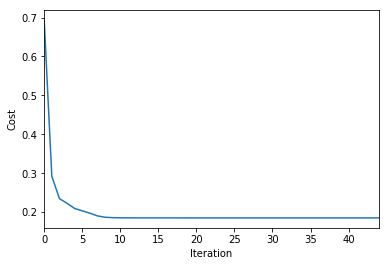

In [40]:
pd.Series(training_summary.objectiveHistory).plot()
plt.xlabel("Iteration")
plt.ylabel("Cost")

Find area under the curve. Closer to 1 is better

In [41]:
training_summary.areaUnderROC

0.9998771122211515

In [42]:
predictions = lr_model.transform(testing).withColumn("match", expr("prediction == sentiment_idx"))

In [43]:
predictions.select("prediction", "sentiment_idx", "sentiment", "match").sample(False, 0.01).show(10)

+----------+-------------+---------+-----+
|prediction|sentiment_idx|sentiment|match|
+----------+-------------+---------+-----+
|       1.0|          1.0|      neg| true|
|       1.0|          1.0|      neg| true|
|       1.0|          1.0|      neg| true|
|       1.0|          1.0|      neg| true|
|       0.0|          0.0|      pos| true|
|       1.0|          1.0|      neg| true|
|       0.0|          0.0|      pos| true|
|       0.0|          0.0|      pos| true|
|       0.0|          0.0|      pos| true|
|       0.0|          0.0|      pos| true|
+----------+-------------+---------+-----+
only showing top 10 rows



In [44]:
predictions.groupBy("sentiment_idx").pivot("prediction").count().show()

+-------------+----+----+
|sentiment_idx| 0.0| 1.0|
+-------------+----+----+
|          0.0|6779| 728|
|          1.0| 890|6522|
+-------------+----+----+



Find the accuracy of the prediction

In [45]:
accuracy = predictions.select(expr("sum(cast(match as int))")).first()[0] / predictions.count()
accuracy

0.8915476908639989